# Climate Change and Impacts in Africa

According to the [United Nations](https://www.un.org/en/climatechange/what-is-climate-change), Climate change refers to long-term shifts in temperatures and weather patterns. Such shifts can be natural, due to changes in the sun’s activity or large volcanic eruptions. But since the 1800s, **human activities** have been the main driver of climate change, primarily due to the burning of fossil fuels like coal, oil, and gas.

The consequences of climate change now include, among others, intense droughts, water scarcity, severe fires, rising sea levels, flooding, melting polar ice, catastrophic storms, and declining biodiversity.

You work for a Non-governmental organization tasked with reporting the state of climate change in Africa at the upcoming African Union Summit. The head of analytics has provided you with [IEA-EDGAR CO2 dataset](https://docs.google.com/spreadsheets/d/1cNhVUPKYP79AayGJp89_tXCJmHoxQO4cwiaseSziwbY/edit#gid=191680117) which you will clean, combine and analyze to create a report on the state of climate change in Africa. You will also provide insights on the impact of climate change on African regions (with four countries, one from each African region, as case studies). 

## Dataset

*The dataset, IEA-EDGAR CO2, is a component of the EDGAR (Emissions Database for Global Atmospheric Research) Community GHG database version 7.0 (2022) including or based on data from IEA (2021) Greenhouse Gas Emissions from Energy, www.iea.org/statistics, as modified by the Joint Research Centre. The data source was the [EDGARv7.0_GHG website](https://edgar.jrc.ec.europa.eu/dataset_ghg70) provided by Crippa *et. al.* (2022) and with [DOI](https://data.europa.eu/doi/10.2904/JRC_DATASET_EDGAR).*

The dataset contains three sheets - `IPCC 2006`, `1PCC 1996`, and `TOTALS BY COUNTRY` on the amount of CO2 (a greenhouse gas) generated by countries between 1970 and 2021. **You can download the dataset from your workspace or inspect the dataset directly [here](https://docs.google.com/spreadsheets/d/1cNhVUPKYP79AayGJp89_tXCJmHoxQO4cwiaseSziwbY/edit#gid=191680117)**.

### TOTALS BY COUNTRY SHEET

This sheet contains the annual CO2 (kt) produced between 1970 - 2021 in each country. The relevant columns in this sheet are:

| Columns | Description |
| ------- | ------------|
| `C_group_IM24_sh` | The region of the world |
| `Country_code_A3` | The country code |
| `Name`            | The name of the country |
| `Y_1970 - Y_2021` | The amount of CO2 (kt) from 1970 - 2021 |


### IPCC 2006

These sheets contain the amount of CO2 by country and the industry responsible. 

| Columns | Description |
| ------- | ------------|
| `C_group_IM24_sh` | The region of the world |
| `Country_code_A3` | The country code |
| `Name`            | The name of the country |
| `Y_1970 - Y_2021` | The amount of CO2 (kt) from 1970 - 2021 |
| `ipcc_code_2006_for_standard_report_name` | The industry responsible for generating CO2 |

## Instructions

The head of analytics in your organization has specifically asked you to do the following:


1. Clean and tidy the datasets. 
2. Create a line plot to show the trend of `CO2` levels across the African regions.
3. Determine the relationship between time (`Year`) and `CO2` levels across the African regions.
4. Determine if there is a significant difference in the `CO2` levels among the African Regions.
5. Determine the most common (top 5) industries in each African region.
6. Determine the industry responsible for the most amount of CO2 (on average) in each African Region.
7. Predict the `CO2` levels (at each African region) in the year 2025.
8. Determine if `CO2` levels affect annual `temperature` in the selected African countries.

In [85]:
# Setup
import pandas as pd
import numpy as np
import pingouin
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
import seaborn as sns
import matplotlib.pyplot as plt
import inspect

plt.style.use('ggplot')
# The sheet names containing the datasets
sheet_names = ['IPCC 2006', 'TOTALS BY COUNTRY']

# The column names of the dataset starts from rows 11
datasets = pd.read_excel('IEA_EDGAR_CO2_1970-2021.xlsx', sheet_name = sheet_names, skiprows = 10)

# Get African regions
african_regions = ['Eastern_Africa', 'Western_Africa', 'Southern_Africa', 'Northern_Africa']

ipcc_2006_africa = datasets['IPCC 2006'].query('C_group_IM24_sh in @african_regions')

totals_by_country_africa = datasets['TOTALS BY COUNTRY'].query('C_group_IM24_sh in @african_regions')

# Read the temperatures datasets containing four African countries
# One from each African Region:
# Nigeria:    West Africa
# Ethiopa :   East Africa
# Tunisia:    North Africa
# Mozambique: South Africa
temperatures = pd.read_csv('temperatures.csv')

## Instruction 1: Clean and tidy the datasets

In [86]:
# Rename columns `C_group_IM24_sh` -> `Region`, 
#                `Country_code_A3` -> `Code`, 
#                `ipcc_code_2006_for_standard_report_name` -> `Industry`:
ipcc_2006_africa = ipcc_2006_africa.rename(columns={'C_group_IM24_sh': 'Region', 'Country_code_A3': 'Code', 'ipcc_code_2006_for_standard_report_name': 'Industry'})
totals_by_country_africa = totals_by_country_africa.rename(columns={'C_group_IM24_sh': 'Region', 'Country_code_A3': 'Code'})

# Drop `IPCC_annex`, `ipcc_code_2006_for_standard_report`, `Substance`:
ipcc_2006_africa = ipcc_2006_africa.drop(['IPCC_annex', 'ipcc_code_2006_for_standard_report', 'Substance'], axis=1)
totals_by_country_africa = totals_by_country_africa.drop(['IPCC_annex', 'Substance'], axis=1)

# Melt `Y_1970` to `Y_2021` into `Year` and `CO2`:
ipcc_2006_africa_long = (ipcc_2006_africa.melt(id_vars=['Region', 'Code', 'Name', 'Industry', 'fossil_bio'], var_name='Year', value_name='CO2'))

totals_by_country_africa_long = (totals_by_country_africa.melt(id_vars=['Region', 'Code', 'Name'], var_name='Year', value_name='CO2'))

#Drop rows where `CO2` is missing:
ipcc_2006_africa_long = ipcc_2006_africa_long.dropna(subset=['CO2'])
totals_by_country_africa_long = totals_by_country_africa_long.dropna(subset=['CO2'])

# Convert column to an integer type:
ipcc_2006_africa_long['Year'] = ipcc_2006_africa_long['Year'].astype(str).str.replace('Y_', '').astype(int)

totals_by_country_africa_long['Year'] = totals_by_country_africa_long['Year'].astype(str).str.replace('Y_', '').astype(int)

#rename long Dataframe:
ipcc_2006_africa = ipcc_2006_africa_long
totals_by_country_africa = totals_by_country_africa_long

print(ipcc_2006_africa.head())
print(totals_by_country_africa)

            Region Code    Name  ... fossil_bio  Year          CO2
0  Southern_Africa  AGO  Angola  ...        bio  1970   468.101210
1  Southern_Africa  AGO  Angola  ...        bio  1970  9803.605447
3  Southern_Africa  AGO  Angola  ...        bio  1970  1168.997514
4  Southern_Africa  AGO  Angola  ...     fossil  1970   137.584287
5  Southern_Africa  AGO  Angola  ...     fossil  1970    74.805080

[5 rows x 7 columns]
               Region Code                         Name  Year            CO2
0     Southern_Africa  AGO                       Angola  1970   20393.274068
1      Eastern_Africa  BDI                      Burundi  1970    4385.562636
2      Western_Africa  BEN                        Benin  1970    4318.786819
3      Western_Africa  BFA                 Burkina Faso  1970    8158.106987
4     Southern_Africa  BWA                     Botswana  1970     947.246888
...               ...  ...                          ...   ...            ...
2907  Southern_Africa  TZA  Tanzania_

Text(0, 0.5, 'CO2(kt)')

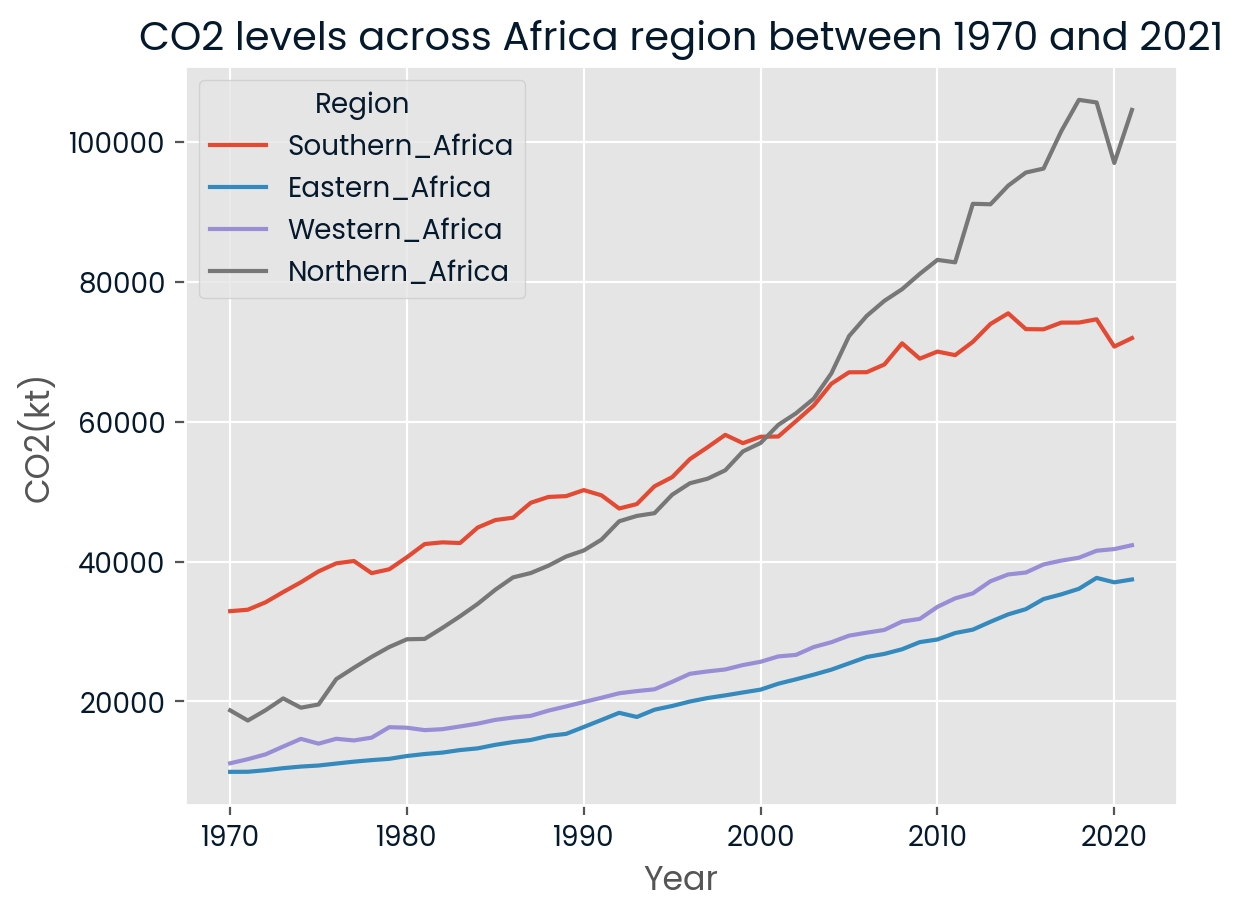

In [87]:
#Lineplot of totals_by_country_africa:
sns.lineplot(
    x = 'Year',
    y = 'CO2',
    hue = 'Region',
    data = totals_by_country_africa,
    ci = None
    )
plt.title('CO2 levels across Africa region between 1970 and 2021')
plt.ylabel('CO2(kt)')

## Instruction 3: Determine the relationship between time (`Year`) and `CO2` levels across the African regions

In [88]:
#Spearman correlation grouped by ragion: 
relationship_btw_time_CO2 = (totals_by_country_africa.groupby('Region')[['Year', 'CO2']]).corr(method = 'spearman')
print(relationship_btw_time_CO2)

                          Year       CO2
Region                                  
Eastern_Africa  Year  1.000000  0.181768
                CO2   0.181768  1.000000
Northern_Africa Year  1.000000  0.429875
                CO2   0.429875  1.000000
Southern_Africa Year  1.000000  0.260986
                CO2   0.260986  1.000000
Western_Africa  Year  1.000000  0.324071
                CO2   0.324071  1.000000


## Instruction 4: Determine if there is a significant difference in the CO2 levels among the African Regions

In [89]:
# ANOVA using totals_by_country_africa:
aov_results = pingouin.anova(data = totals_by_country_africa,
                             dv = "CO2",
                             between = "Region")
print(aov_results)

#Posthoc test (with Bonferroni correction):
pw_ttest_result = pingouin.pairwise_tests(data = totals_by_country_africa,
                                           dv = "CO2",
                                           between = "Region",
                                           padjust = 'bonf')

print(pw_ttest_result)

   Source  ddof1  ddof2          F         p-unc       np2
0  Region      3   2908  35.558065  1.455509e-22  0.035385
  Contrast                A                B  ...  p-adjust       BF10    hedges
0   Region   Eastern_Africa  Northern_Africa  ...      bonf  1.554e+17 -0.801390
1   Region   Eastern_Africa  Southern_Africa  ...      bonf  4.024e+08 -0.421846
2   Region   Eastern_Africa   Western_Africa  ...      bonf      0.173 -0.059094
3   Region  Northern_Africa  Southern_Africa  ...      bonf      0.079  0.004785
4   Region  Northern_Africa   Western_Africa  ...      bonf  9.641e+10  0.418029
5   Region  Southern_Africa   Western_Africa  ...      bonf  5.437e+05  0.335300

[6 rows x 13 columns]


## Instruction 5: Determine the most common (top 5) industries in each African region.

In [90]:
# Group the `ipcc_2006_africa` data by `Region` and `Industry` and count the occurrences of each `Industry` within each `Region` and name it `Count`:
ipcc_2006_africa_grouped = ipcc_2006_africa.groupby(['Region', 'Industry']).size().reset_index(name='Count')

#Sort the data within each region group by `Count` in descending order:
ipcc_2006_africa_sorted = ipcc_2006_africa_grouped.sort_values(by=['Region', 'Count'], ascending = [True, False])

#Top 5 industries for each region:
top_5_industries = ipcc_2006_africa_sorted.groupby('Region').head(5).reset_index(drop = True)

print(top_5_industries)


             Region                                        Industry  Count
0    Eastern_Africa                   Residential and other sectors   1454
1    Eastern_Africa       Manufacturing Industries and Construction   1383
2    Eastern_Africa   Main Activity Electricity and Heat Production   1174
3    Eastern_Africa             Road Transportation no resuspension    742
4    Eastern_Africa                                Glass Production    728
5   Northern_Africa                   Residential and other sectors    572
6   Northern_Africa       Manufacturing Industries and Construction    456
7   Northern_Africa   Main Activity Electricity and Heat Production    315
8   Northern_Africa                                Glass Production    312
9   Northern_Africa  Non-Energy Products from Fuels and Solvent Use    312
10  Southern_Africa                   Residential and other sectors   1144
11  Southern_Africa       Manufacturing Industries and Construction   1067
12  Southern_Africa   Mai

## Instruction 6: Determine the industry responsible for the most amount of CO2 (on average) in each African Region

In [91]:
#Group the ipcc_2006_africa data by Region and Industry and average CO2 emmision per industry:
ipcc_2006_africa_grouped_mean = ipcc_2006_africa.groupby(['Region', 'Industry'])['CO2'].mean().reset_index()

#Industry with the maximum average CO2 emissions in each region:
max_co2_industries = ipcc_2006_africa_grouped_mean.loc[ipcc_2006_africa_grouped_mean.groupby('Region')['CO2'].idxmax()].reset_index(drop=True)

print(max_co2_industries)

            Region                                       Industry           CO2
0   Eastern_Africa                  Residential and other sectors   7904.439282
1  Northern_Africa  Main Activity Electricity and Heat Production  13612.230148
2  Southern_Africa  Main Activity Electricity and Heat Production  11377.802504
3   Western_Africa                  Residential and other sectors   8702.936136


## Instruction 7: Predict the `CO2` levels (at each African region) in the year 2025

In [92]:
# data provided for you
newdata = pd.DataFrame({ 'Year': 2025, 'Region': african_regions })
newdata = pd.get_dummies(newdata)

#Create an instance of LinearRegression() and save it as reg:
reg = LinearRegression()

# Set the features:
features = pd.get_dummies(totals_by_country_africa[['Year' , 'Region']])

#Set the target:
target = np.log10(totals_by_country_africa['CO2'])

#Fit a linear model of CO2 (in log base 10) by Year and Region using reg.fit():
reg.fit(features, target)

#Predict the values of CO2:
predicted_co2 = reg.predict(newdata)

#Convert predicted_co2:
predicted_co2 = np.round(10**predicted_co2, 2)

print(predicted_co2)

[15177.72 10788.07 37761.69 41081.9 ]


## Instruction 8: Determine if CO2 levels affect annual temperature in the selected African countries

Index(['Year', 'Name', 'Temperature', 'Region', 'Code', 'CO2'], dtype='object')


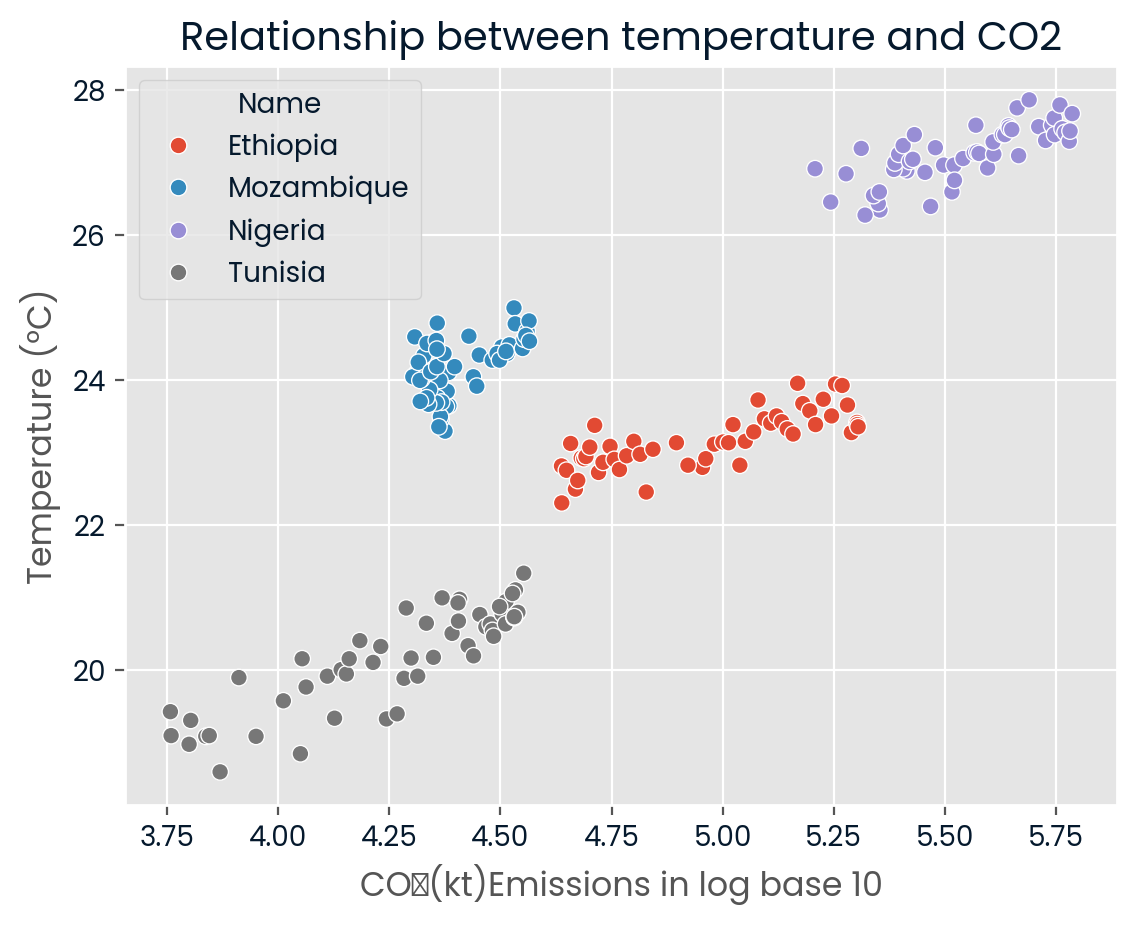

In [93]:
# Change temperature dataframe from wide to long
temperatures_long = pd.melt(temperatures, id_vars='Year', 
                    var_name='Name', 
                    value_name='Temperature')

# Merge dataframe to get CO2 values for each year and region
df_merged = pd.merge(temperatures_long, totals_by_country_africa, on=['Year', 'Name'], how='inner')

print(df_merged.columns)

# Add log10 of CO2 to the DataFrame
df_merged['log_CO2'] = np.log10(df_merged['CO2'])

#Scatterplot of temperature and CO2
sns.scatterplot(
    x='log_CO2',
    y='Temperature',
    hue='Name',
    data=df_merged
)
plt.title('Relationship between temperature and CO2')
plt.xlabel('CO₂(kt)Emissions in log base 10')
plt.ylabel('Temperature (°C)')
plt.show()

In [94]:
countries = ["Ethiopia", "Mozambique", "Nigeria", "Tunisia"]

selected_countries = totals_by_country_africa[['Name', 'Year', 'CO2']].query('Name in @countries')

#Convert `temperatures` dataset from wide to long format:
temp_long = (temperatures.melt(id_vars = ['Year'], value_vars = countries, var_name = 'Name', value_name = 'Temperature'))

#Perform an inner join between `selected_countries` and `temp_long` on `Name` and `Year`:
joined = pd.merge(selected_countries, temp_long, on=['Name', 'Year'], how='inner')

model_temp = OLS.from_formula("Temperature ~ np.log10(CO2) + Name", data = joined).fit()
model_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Temperature   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     3241.
Date:                Thu, 03 Jul 2025   Prob (F-statistic):          1.22e-182
Time:                        19:20:44   Log-Likelihood:                -54.347
No. Observations:                 208   AIC:                             118.7
Df Residuals:                     203   BIC:                             135.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             13.4981      0.583     23.138      0.000      12.348      14.648
Name[T.Mozambique]     2.0759      0.090     23.021      0.000       1.898       2.254
Name[T.Nigeria]        2.8345      0.092     30.884      0.000       2.654       3.016
Name[T.Tunisia]       -1.6254      0.104    -15.673      0.000      -1.830      -1.421
np.log10(CO2)          1.9472      0.117     16.620      0.000       1.716       2.178
==============================================================================
Omnibus:                        3.230   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.199   Jarque-Bera (JB):                2.985
Skew:                          -0.291   Prob(JB):                        0.225
Kurtosis:                       3.073   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""